I implemented the Deep CNN model described in Salamon and Bello's paper (Salamon, Justin, and Juan Pablo Bello. "Deep convolutional neural networks and data augmentation for environmental sound classification." IEEE Signal processing letters 24.3 (2017): 279-283.) for environmental sound classification in this code. The data set used for this model is already processed in the other part of the code.

In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sn
import pandas as pd
from librosa.feature import melspectrogram
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split


## Load from the saved data

In [3]:
# For Colab only
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
X = np.load('gdrive/My Drive/CNN paper for sound classification/allfolds_features_x.npy')
y = np.load('gdrive/My Drive/CNN paper for sound classification/allfolds_labels_y.npy')

In [6]:
# For Jupyter Notebook only
# X=np.load('UrbanSound8K\\UrbanSound8K_Processed\\allfolds_features_x.npy')
# y=np.load('UrbanSound8K\\UrbanSound8K_Processed\\allfolds_labels_y.npy')

In [7]:
X_train_i, X_test, y_train_i, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train_i, y_train_i, test_size=0.25)


# Model

In [21]:
frames = 128
bands = 128
feature_size = frames* bands 
num_channels = 1
num_labels = 10 # number of output predictions

In [35]:
def build_model():
  f_size = 5
  model = Sequential()
  model.add(Convolution2D(24, (f_size, f_size), strides=(1,1), padding='valid', input_shape=(bands, frames, num_channels)))
  model.add(MaxPooling2D(pool_size=(4, 2)))
  model.add(Activation('relu'))
  model.add(Convolution2D(48, (5, 5), strides=(1,1), padding='valid'))
  model.add(MaxPooling2D(pool_size=(4, 2)))
  model.add(Activation('relu'))
  model.add(Convolution2D(48, (5, 5), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(64, kernel_regularizer=l2(0.001)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="SGD")
  return model

In [36]:
print("Building model...")
model = build_model()
history = model.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=100, epochs=200)

Building model...
Epoch 1/200
53/53 [==============================] - 4s 59ms/step - loss: 3.3305 - accuracy: 0.1365 - val_loss: 2.3515 - val_accuracy: 0.2456
Epoch 2/200
53/53 [==============================] - 3s 51ms/step - loss: 2.3797 - accuracy: 0.1859 - val_loss: 2.3277 - val_accuracy: 0.2055
Epoch 3/200
53/53 [==============================] - 3s 52ms/step - loss: 2.3414 - accuracy: 0.1901 - val_loss: 2.2289 - val_accuracy: 0.3297
Epoch 4/200
53/53 [==============================] - 3s 52ms/step - loss: 2.2967 - accuracy: 0.2159 - val_loss: 2.1731 - val_accuracy: 0.3343
Epoch 5/200
53/53 [==============================] - 3s 51ms/step - loss: 2.2648 - accuracy: 0.2308 - val_loss: 2.1128 - val_accuracy: 0.3543
Epoch 6/200
53/53 [==============================] - 3s 52ms/step - loss: 2.2313 - accuracy: 0.2404 - val_loss: 2.0439 - val_accuracy: 0.3898
Epoch 7/200
53/53 [==============================] - 3s 51ms/step - loss: 2.2222 - accuracy: 0.2434 - val_loss: 2.0140 - val_accur

The Evaluation code is based on example code posted by jaron https://github.com/jaron/deep-listening

Evaluating model...
55/55 [==============================] - 1s 9ms/step - loss: 0.7121 - accuracy: 0.8569

Accuracy = 0.86
History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


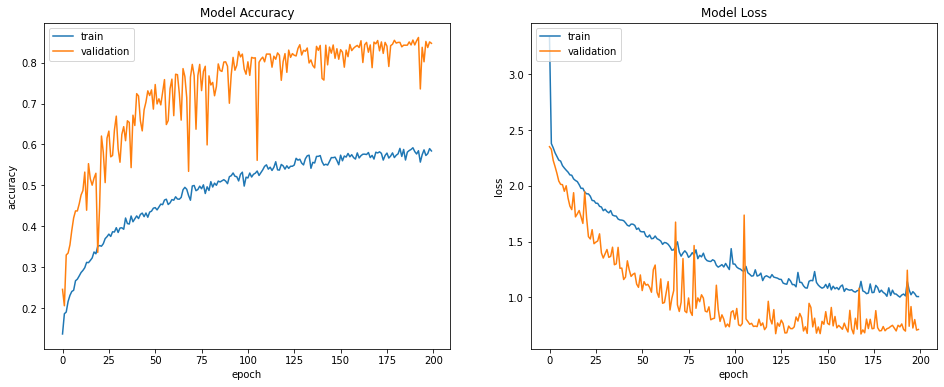

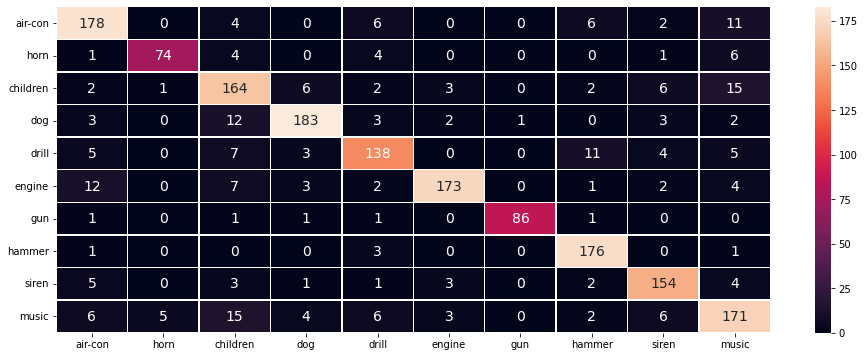

In [37]:
print("Evaluating model...")
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob,1)
y_true = np.argmax(y_test, 1)
_, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print("\nAccuracy = {:.2f}".format(accuracy))
fig = plt.figure(figsize=(16,6))
print ("History keys:", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

labels = ["air-con","horn","children","dog","drill","engine","gun","hammer","siren","music"]
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (16,6))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)

## Box plot on 50 Epochs and 10 iterations

In [39]:
accuracy_array=[]

for i in range(1,11):
  print("Iteration...",i)
  X_train_i, X_test, y_train_i, y_test = train_test_split(X, y, test_size=0.20,random_state=40)
  X_train, X_val, y_train, y_val = train_test_split(X_train_i, y_train_i, test_size=0.25,random_state=40)
  print("Building model...")
  model = build_model()
  history = model.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=100, epochs=50)
  print("Evaluating model...")
  y_prob = model.predict(X_test, verbose=0)
  y_pred = np.argmax(y_prob,1)
  y_true = np.argmax(y_test, 1)
  _, accuracy = model.evaluate(X_test, y_test, batch_size=32)
  accuracy_array.append(accuracy)

Iteration... 1
Building model...
Epoch 1/50
53/53 [==============================] - 4s 60ms/step - loss: 3.5323 - accuracy: 0.1182 - val_loss: 2.4172 - val_accuracy: 0.1551
Epoch 2/50
53/53 [==============================] - 3s 51ms/step - loss: 2.4290 - accuracy: 0.1501 - val_loss: 2.3801 - val_accuracy: 0.2066
Epoch 3/50
53/53 [==============================] - 3s 51ms/step - loss: 2.4054 - accuracy: 0.1455 - val_loss: 2.3647 - val_accuracy: 0.2232
Epoch 4/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3945 - accuracy: 0.1615 - val_loss: 2.3292 - val_accuracy: 0.2507
Epoch 5/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3765 - accuracy: 0.1739 - val_loss: 2.2970 - val_accuracy: 0.2896
Epoch 6/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3536 - accuracy: 0.1921 - val_loss: 2.2806 - val_accuracy: 0.2948
Epoch 7/50
53/53 [==============================] - 3s 51ms/step - loss: 2.3302 - accuracy: 0.2029 - val_loss: 2.2391 - v

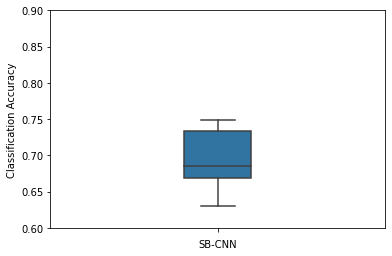

In [47]:
boxplot=sn.boxplot(y=accuracy_array,width=0.2)
boxplot.set(ylabel='Classification Accuracy',xlabel='SB-CNN')
boxplot.set(ylim=(0.6, 0.9))
plt.show()